In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import folium
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
# =================================================================
# 1. GÉNÉRATION DE DONNÉES AIS AVEC TRAJECTOIRES
# =================================================================

def generate_ais_trajectories(n_points=500):
    """
    Génère des données AIS incluant des coordonnées GPS.
    """
    np.random.seed(42)
    
    # --- TRANSIT ---
    # Un navire qui part d'un point A vers un point B (ligne droite rapide)
    sog_transit = np.random.normal(15, 0.5, n_points)
    cog_transit = np.random.normal(45, 1, n_points) # Direction Nord-Est
    
    # --- SONDAGE ---
    # Un navire qui fait des allers-retours ou stagne (lent et sinueux)
    sog_survey = np.random.normal(3, 0.8, n_points)
    cog_survey = np.random.normal(180, 40, n_points) # Direction très variable
    
    activities = ["Transit"] * n_points + ["Sondage"] * n_points
    sogs = np.concatenate([sog_transit, sog_survey])
    cogs = np.concatenate([cog_transit, cog_survey])
    
    # Simulation simplifiée de la dérive GPS (Lat/Lon)
    lats, lons = [48.0], [-5.0] # Point de départ au large de la Bretagne
    for i in range(len(sogs) - 1):
        # Approximation : distance parcourue en 1 min selon SOG et COG
        dist = sogs[i] / 60.0
        new_lat = lats[-1] + (dist * np.cos(np.radians(cogs[i]))) / 60.0
        new_lon = lons[-1] + (dist * np.sin(np.radians(cogs[i]))) / (60.0 * np.cos(np.radians(lats[-1])))
        lats.append(new_lat)
        lons.append(new_lon)

    df = pd.DataFrame({
        'timestamp': pd.date_range(start='2024-01-01', periods=n_points*2, freq='1min'),
        'mmsi': [123456789] * (n_points*2), # ID unique du navire
        'latitude': lats,
        'longitude': lons,
        'SOG': sogs,
        'COG': cogs,
        'activity': activities
    })
    return df

In [18]:
# =================================================================
# 2. FEATURE ENGINEERING & EXPORT CSV
# =================================================================

def process_and_export(df):
    # Calcul de variables dérivées (Stabilité du cap)
    df['COG_std_5m'] = df['COG'].rolling(window=5).std()
    df['SOG_mean_5m'] = df['SOG'].rolling(window=5).mean()
    
    # Nettoyage
    df_clean = df.dropna()
    
    # EXPORT CSV
    filename = "dataset_ais_simule.csv"
    df_clean.to_csv(filename, index=False)
    print(f"✅ Dataset exporté avec succès : {filename}")
    
    return df_clean

In [19]:
# =================================================================
# 3. FEATURE ENGINEERING ET CARTE INTERACTIVE
# =================================================================

def create_interactive_map(df, output_file="trajectoire_ais.html"):
    """ Génère une carte Folium avec des traces de couleurs différentes. """
    m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)
    
    # Séparation des segments pour la couleur
    for activity, color in zip(['Transit', 'Sondage'], ['blue', 'red']):
        subset = df[df['activity'] == activity]
        points = list(zip(subset['latitude'], subset['longitude']))
        folium.PolyLine(points, color=color, weight=3, opacity=0.8, tooltip=activity).add_to(m)
        # Ajouter un marqueur au début de chaque phase
        folium.Marker(points[0], popup=f"Début {activity}", icon=folium.Icon(color=color)).add_to(m)
        
    m.save(output_file)
    print(f"🌍 Carte interactive générée : {output_file}")

def process_data(df):
    df['COG_std_5m'] = df['COG'].rolling(window=5).std()
    df['SOG_mean_5m'] = df['SOG'].rolling(window=5).mean()
    df['delta_SOG'] = df['SOG'].diff().abs()
    return df.dropna()


✅ Dataset exporté avec succès : dataset_ais_simule.csv

--- Aperçu du Dataset ---
            timestamp       mmsi   latitude  longitude        SOG        COG  \
4 2024-01-01 00:04:00  123456789  48.011927  -4.981865  14.882923  44.349357   
5 2024-01-01 00:05:00  123456789  48.014884  -4.977545  14.882932  44.512875   
6 2024-01-01 00:06:00  123456789  48.017832  -4.973213  15.789606  44.407606   
7 2024-01-01 00:07:00  123456789  48.020965  -4.968624  15.383717  44.136009   
8 2024-01-01 00:08:00  123456789  48.024032  -4.964175  14.765263  45.048522   

  activity  COG_std_5m  SOG_mean_5m  
4  Transit    1.307267    15.229501  
5  Transit    1.282440    15.156416  
6  Transit    0.701402    15.328164  
7  Transit    0.558979    15.340139  
8  Transit    0.340714    15.140888  


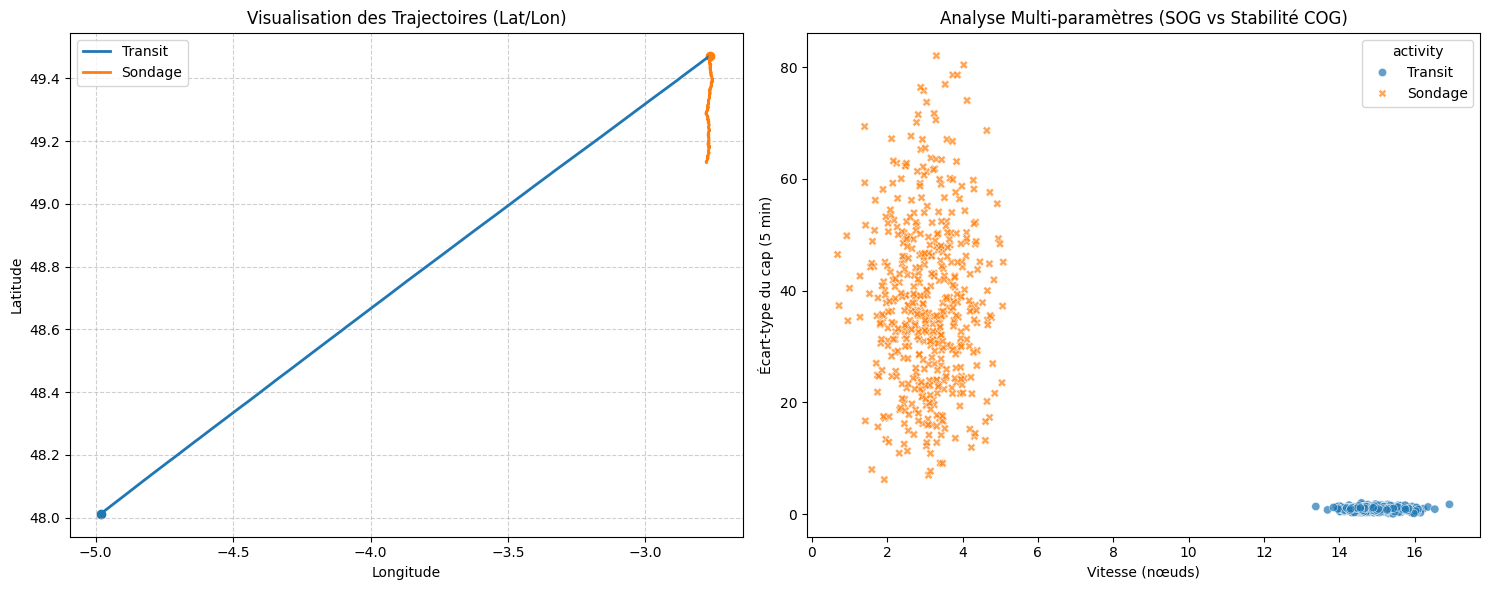

In [20]:
# =================================================================
# 4. VISUALISATION DES DONNÉES
# =================================================================

def visualize_dataset(df):
    plt.figure(figsize=(15, 6))
    
    # Plot 1 : La trajectoire géographique
    plt.subplot(1, 2, 1)
    for activity in df['activity'].unique():
        subset = df[df['activity'] == activity]
        plt.plot(subset['longitude'], subset['latitude'], label=activity, lw=2)
        # Marquer le début
        plt.scatter(subset['longitude'].iloc[0], subset['latitude'].iloc[0], marker='o')
        
    plt.title("Visualisation des Trajectoires (Lat/Lon)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot 2 : Corrélation Vitesse vs Variabilité
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x='SOG', y='COG_std_5m', hue='activity', style='activity', alpha=0.7)
    plt.title("Analyse Multi-paramètres (SOG vs Stabilité COG)")
    plt.xlabel("Vitesse (nœuds)")
    plt.ylabel("Écart-type du cap (5 min)")
    
    plt.tight_layout()
    plt.show()

# --- Exécution ---
if __name__ == "__main__":
    raw_data = generate_ais_trajectories()
    processed_data = process_and_export(raw_data)
    
    print("\n--- Aperçu du Dataset ---")
    print(processed_data.head())
    
    visualize_dataset(processed_data)

In [21]:

# =================================================================
# 5. FEATURE ENGINEERING (LE CŒUR DU PROJET)
# =================================================================

def engineer_features(df):
    """
    Crée des variables calculées pour capturer la signature de l'activité.
    """
    # Calcul de la variation de vitesse (accélération)
    df['delta_SOG'] = df['SOG'].diff().abs()
    
    # Calcul de la variation de cap (Turning Rate)
    # On gère le passage de 359° à 0°
    df['delta_COG'] = df['COG'].diff().abs()
    df['delta_COG'] = df['delta_COG'].apply(lambda x: 360 - x if x > 180 else x)
    
    # Moyennes mobiles pour capturer le comportement sur une fenêtre de 5 min
    df['SOG_rolling_mean'] = df['SOG'].rolling(window=5).mean()
    df['SOG_rolling_std'] = df['SOG'].rolling(window=5).std()
    df['COG_rolling_std'] = df['COG'].rolling(window=5).std()
    
    # Ratio Vitesse / Stabilité du cap (plus c'est bas, plus c'est probablement du travail)
    df['efficiency_index'] = df['SOG'] / (df['delta_COG'] + 1)
    
    return df.dropna()



--- Chargement et préparation des données ---

--- Rapport de Classification ---
              precision    recall  f1-score   support

     Sondage       1.00      1.00      1.00       300
     Transit       1.00      1.00      1.00       299

    accuracy                           1.00       599
   macro avg       1.00      1.00      1.00       599
weighted avg       1.00      1.00      1.00       599


--- Importance des Features (Le levier de décision) ---
SOG                 0.389080
SOG_rolling_mean    0.251761
COG_rolling_std     0.167295
efficiency_index    0.144337
delta_COG           0.045325
SOG_rolling_std     0.002200
delta_SOG           0.000002
dtype: float64


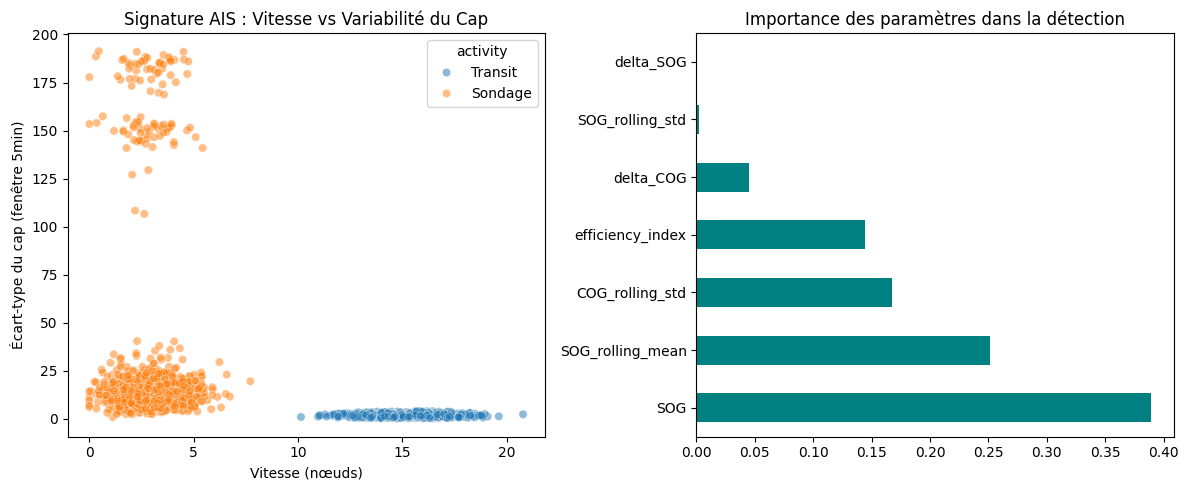


Conclusion du projet :
Le modèle identifie parfaitement les activités de sondage grâce à la combinaison
de la faible vitesse (SOG) et de la forte variabilité du cap (COG_rolling_std).


In [22]:
# =================================================================
# 6. ANALYSE ET MODÉLISATION
# =================================================================

print("--- Chargement et préparation des données ---")
data = generate_ais_data()
data = engineer_features(data)

# Visualisation des profils
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data, x='SOG', y='COG_rolling_std', hue='activity', alpha=0.5)
plt.title("Signature AIS : Vitesse vs Variabilité du Cap")
plt.xlabel("Vitesse (nœuds)")
plt.ylabel("Écart-type du cap (fenêtre 5min)")

# Préparation du modèle
features = ['SOG', 'delta_SOG', 'delta_COG', 'SOG_rolling_mean', 'SOG_rolling_std', 'COG_rolling_std', 'efficiency_index']
X = data[features]
y = data['activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement d'un classifieur Random Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Évaluation
y_pred = model.predict(X_test)
print("\n--- Rapport de Classification ---")
print(classification_report(y_test, y_pred))

# Importance des variables (Crucial pour l'entretien technique)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Importance des Features (Le levier de décision) ---")
print(importances)

# Conclusion visuelle
plt.subplot(1, 2, 2)
importances.plot(kind='barh', color='teal')
plt.title("Importance des paramètres dans la détection")
plt.tight_layout()
plt.show()

print("\nConclusion du projet :")
print("Le modèle identifie parfaitement les activités de sondage grâce à la combinaison")
print("de la faible vitesse (SOG) et de la forte variabilité du cap (COG_rolling_std).")

🌍 Carte interactive générée : trajectoire_ais.html

--- Analyse de Performance ---
              precision    recall  f1-score   support

     Sondage       1.00      1.00      1.00       145
     Transit       1.00      1.00      1.00       154

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



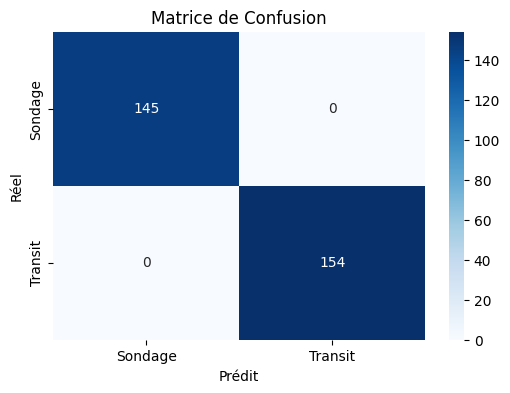

In [23]:
# =================================================================
# 7. MODÉLISATION ET ANALYSE
# =================================================================

if __name__ == "__main__":
    # 1. Préparation
    raw_data = generate_ais_trajectories()
    create_interactive_map(raw_data)
    df = process_data(raw_data)
    
    # 2. Split
    features = ['SOG', 'COG_std_5m', 'SOG_mean_5m', 'delta_SOG']
    X = df[features]
    y = df['activity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # 3. Training
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # 4. Résultats
    y_pred = clf.predict(X_test)
    print("\n--- Analyse de Performance ---")
    print(classification_report(y_test, y_pred))
    
    # Matrice de confusion pour le README
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
    plt.title("Matrice de Confusion")
    plt.ylabel('Réel')
    plt.xlabel('Prédit')
    plt.show()